
===== Fold 1 =====
Fold 1 Test Accuracy: 0.8514

===== Fold 2 =====
Fold 2 Test Accuracy: 0.8219

===== Fold 3 =====
Fold 3 Test Accuracy: 0.8082

===== Fold 4 =====
Fold 4 Test Accuracy: 0.6712

===== Fold 5 =====
Fold 5 Test Accuracy: 0.7945

Mean Cross-Validation Accuracy: 0.7894


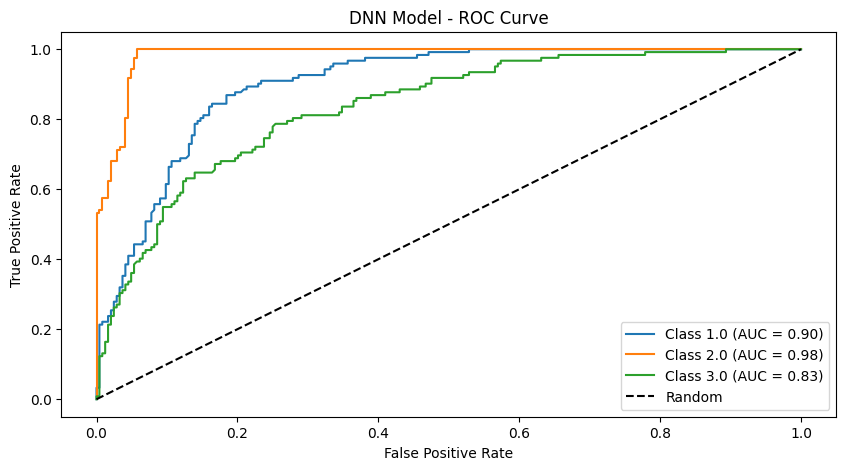

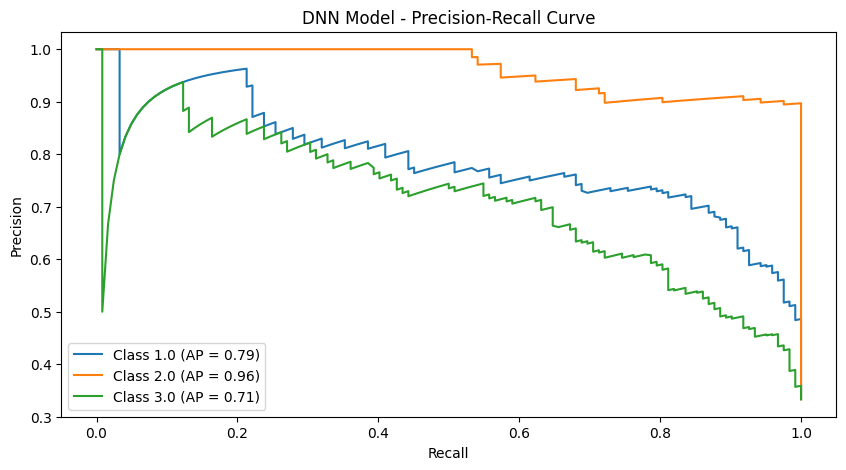

In [31]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import GroupKFold
from imblearn.over_sampling import SMOTE

# Load Data
merged_data = pd.read_csv("/Users/jiayingyou/Downloads/ar_mutants/merged_dataset.csv", index_col=False)
drug_data = pd.read_csv("/Users/jiayingyou/Downloads/ar_mutants/morgan_fp_drug_128.csv")
protein_data = pd.read_csv("/Users/jiayingyou/Downloads/ar_mutants/protein_desc_mutant.csv")

# Merge Data
merged_data = merged_data.merge(drug_data, on='drug')
merged_data = merged_data.merge(protein_data, on='mutant')

df = merged_data.iloc[:, 1:]  # Remove first column if unnecessary

# Feature Extraction
X = df.iloc[:, 3:].values  # Features
y = df['trend'].values      # Target Variable

# Standardization & PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=128)
X_pca = pca.fit_transform(X_scaled)

# Encode Labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Load Group Labels Before SMOTE
groups = df['mutant'].values  # Grouping based on mutant

# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_pca, y_encoded)

# Expand groups to match new SMOTE samples
new_groups = np.array([groups[i % len(groups)] for i in range(len(y_resampled))])

# Define GroupKFold cross-validation
gkf = GroupKFold(n_splits=5)

# **Define Neural Network**
class DNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_prob=0.5):
        super(DNNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.fc4 = nn.Linear(hidden_dims[2], output_dim)
        
        # Dropout layers
        self.dropout1 = nn.Dropout(dropout_prob)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.dropout3 = nn.Dropout(dropout_prob)
        
        self.init_weights()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)  # **No Softmax, CrossEntropyLoss handles it**
        return x

    def init_weights(self):
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.xavier_uniform_(self.fc4.weight)

# **Hyperparameters**
input_dim = X_resampled.shape[1]
hidden_dims = [64, 32, 32]
output_dim = len(le.classes_)
learning_rate = 1e-3
batch_size = 256
epochs = 10000
dropout_prob = 0.1

# **Device Setup (GPU if available)**
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Store cross-validation results
cv_results = []
all_true_labels = []
all_pred_probs = []

# **Cross-validation loop**
for fold, (train_idx, test_idx) in enumerate(gkf.split(X_resampled, y_resampled, groups=new_groups)):
    print(f"\n===== Fold {fold + 1} =====")
    
    # Train-test split for this fold
    X_train, X_test = X_resampled[train_idx], X_resampled[test_idx]
    y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

    # Define model
    model = DNNModel(input_dim, hidden_dims, output_dim, dropout_prob).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

    # **Training Loop**
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train_tensor)
        loss = nn.CrossEntropyLoss()(output, y_train_tensor)
        loss.backward()
        optimizer.step()
        scheduler.step()

    # **Evaluation**
    model.eval()
    with torch.no_grad():
        test_output = model(X_test_tensor)
        pred_probs = torch.softmax(test_output, dim=1).cpu().numpy()  # Convert logits to probabilities

        all_true_labels.extend(y_test)
        all_pred_probs.extend(pred_probs)

        _, predicted_test = torch.max(test_output, 1)
        test_accuracy = (predicted_test.cpu().numpy() == y_test).mean()
        print(f"Fold {fold + 1} Test Accuracy: {test_accuracy:.4f}")
        cv_results.append(test_accuracy)

# Convert lists to numpy arrays
all_true_labels = np.array(all_true_labels)
all_pred_probs = np.array(all_pred_probs)

# Compute Mean CV Accuracy
mean_accuracy = np.mean(cv_results)
print(f"\nMean Cross-Validation Accuracy: {mean_accuracy:.4f}")

# **ROC & Precision-Recall Curves**
def plot_roc_curve(true_labels, pred_probs, model_name):
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(output_dim):
        fpr[i], tpr[i], _ = roc_curve(true_labels, pred_probs[:, i], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 5))
    for i in range(output_dim):
        plt.plot(fpr[i], tpr[i], label=f'Class {le.classes_[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(true_labels, pred_probs, model_name):
    precision = {}
    recall = {}
    average_precision = {}

    for i in range(output_dim):
        precision[i], recall[i], _ = precision_recall_curve(true_labels, pred_probs[:, i], pos_label=i)
        average_precision[i] = average_precision_score(true_labels == i, pred_probs[:, i])

    plt.figure(figsize=(10, 5))
    for i in range(output_dim):
        plt.plot(recall[i], precision[i], label=f'Class {le.classes_[i]} (AP = {average_precision[i]:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name} - Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

# Plot ROC and PR curves
plot_roc_curve(all_true_labels, all_pred_probs, 'DNN Model')
plot_precision_recall_curve(all_true_labels, all_pred_probs, 'DNN Model')
